In [2]:
from helpers import *

def od_xml_to_df(file_path):

    tree = ET.parse(file_path)
    root = tree.getroot()
    gt_od_df =  xml2df_str(root, 'tazRelation')
    
    gt_od_vals = gt_od_df['count'].astype(float)
    print('total GT demand: ',gt_od_vals.sum())

    return gt_od_df

In [3]:
base_path = '/Users/rodrse/Downloads/ForSergio_nov26_2023_final'

In [4]:

taz2edge_xml = 'taz_new.xml'
net_xml = 'SFO.net.xml'
fixed_routes_xml = f'{base_path}/5hr_route_choice_set.csv'
od_duration_seconds = 5*60 

# duration of sample time for simulation output statistics
simulation_stat_freq_sec = od_duration_seconds
sim_end_time = od_duration_seconds
additional_xml = f'additional.add_statfreq{od_duration_seconds}.xml'

# suffix of simulation output edge file
EDGE_OUT_STR = 'edge_data_SFO.xml'
TRIPS2ODS_OUT_STR = 'trips.xml'
SUMO_PATH = '/usr/local/opt/sumo/share/sumo'

In [5]:
gt_version_str = 'v4'

# gt v4:
mean_od_val = 100
num_ods = 10

print('if you want to optimize them all (~86k) set num_ods as defined in commented line below')
#num_ods = routes_df.shape[0]

if you want to optimize them all (~86k) set num_ods as defined in commented line below


In [6]:
od_xml = f'gt_od_{gt_version_str}.xml'
file_gt = f'{base_path}/gt_od_{gt_version_str}.xml'
file_gt_edges = f'{base_path}/gt_edges_{gt_version_str}.csv'
prefix_output_gt = f'gt_{gt_version_str}'

In [7]:
# Get GT OD
print("Reading:",file_gt)
tree = ET.parse(file_gt)
root = tree.getroot()
gt_od_df =  xml2df_str(root, 'tazRelation')

gt_od_df.head()

Reading: /Users/rodrse/Downloads/ForSergio_nov26_2023_final/gt_od_v4.xml


,from,to,count,data
0,10100,10400,97.4,None
1,10100,10500,114.9,None
2,10100,105000,104.1,None
3,10100,108100,100.0,None
4,10100,108200,109.1,None


In [8]:
print("Reading:",fixed_routes_xml)
routes_df = pd.read_csv(fixed_routes_xml, index_col=0)

Reading: /Users/rodrse/Downloads/ForSergio_nov26_2023_final/5hr_route_choice_set.csv


In [9]:
gt_od_df = od_xml_to_df(file_gt)

total GT demand:  1044.3999999999999


In [10]:
gt_od_df.columns

Index(['from', 'to', 'count', 'data'], dtype='object')

## Vanilla BO

### Declare parameter space

In [11]:
import torch

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double

### Declare search space
# dimensionality of input space

dim_od = gt_od_df.shape[0]

#bounds = torch.tensor([
#    [ gt_od_df['count'].astype(float).min() - 2 for _ in range(dim_od)],
#    [ gt_od_df['count'].astype(float).max() + 2 for _ in range(dim_od)]
#], device=device, dtype=dtype) 

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype) 


bounds



tensor([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.]],
       dtype=torch.float64)

Read output of GT simulation

In [12]:

sim_edge_out_gt = f'{base_path}/{prefix_output_gt}_{EDGE_OUT_STR}'
df_edge_gt, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out_gt, prefix_output_gt,SUMO_PATH)
# picking at edges as GT edges
num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)
gt_edge_data = df_edge_gt\
    .sort_values(by=['interval_nVehContrib'], ascending=False)\
    .iloc[:num_gt_edges]

#gt_edge_data.shape


Number of GT edges: 197


In [13]:
# Sample according to Sobol
from torch.quasirandom import SobolEngine
from botorch.utils.transforms import unnormalize

n0 = 50
sobol = SobolEngine(dim_od, scramble=True)
x_0 = sobol.draw(n0).to(dtype=dtype)

# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)
#train_X0

In [14]:

#num_epsilon_iter = 2
ods_epsilon = []
loss_all = []
batch_data_i = []

# Base OD which we will update their count entries
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i , x in enumerate(train_X0.tolist()):
#for i , x in enumerate(
#      [[ 94.66438596,  91.97375804, 101.82277249, 112.44778006,
#            105.33019264,  92.62166575,  99.8673423 ,  93.71928772,
#            116.16658554,  94.79717515],
#      [ 97.4, 114.9, 104.1, 100. , 109.1, 106.7,  87.8, 101.1, 113.9,109.4]]):
      print(f"########### OD: {i} ###########")
      print(x)

      file_od_epsilon_xml = f'initial_search/gt_od_{gt_version_str}_{i}.xml'
      prefix_output = f'initial_search/sobol_{i}'

      # Generate OD
      #curr_od = gt_od_vals.copy()
      curr_od = np.array(x)

      print(f'total expected GT demand: {np.sum(curr_od)}')

      ###
      # create OD xml file 
      ###
      base_od['count'] = curr_od
      # round to 1 decimal point
      base_od['count'] = [round(elem, 1) for elem in base_od['count']]     
      base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})        
      create_taz_xml(file_od_epsilon_xml, base_od, od_duration_seconds, base_path)
      ods_epsilon.append(curr_od)

      # simulate gt od
      simulate_od(file_od_epsilon_xml, 
                  prefix_output, 
                  base_path, 
                  net_xml, 
                  taz2edge_xml, 
                  additional_xml, 
                  routes_df,
                  sim_end_time,
                  TRIPS2ODS_OUT_STR)

      ## Compute loss
      #prefix_output = f'initial_search/sobol_{i}'
      sim_edge_out = f'{base_path}/{prefix_output}_{EDGE_OUT_STR}'
      print(sim_edge_out)
      curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output,SUMO_PATH)
      curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)

      loss_all.append(curr_loss)
      print(f"############## loss: {curr_loss} ##############")

      # Parse training data
      df_curr = pd.DataFrame(curr_od.reshape(1,dim_od),
                        columns = [f"x_{i+1}" for i in range(dim_od)])
      df_curr['loss'] = curr_loss
      batch_data_i.append(df_curr)



########### OD: 0 ###########
[1217.2446250915527, 683.7300062179565, 709.1444730758667, 1202.2987604141235, 1418.3646440505981, 144.1548466682434, 1889.4498348236084, 400.5787968635559, 129.0176510810852, 238.0807399749756]
total expected GT demand: 8032.064378261566
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/initial_search/gt_od_v4_0.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/initial_search/gt_od_v4_0.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/initial_search/sobol_0_trips_beforeRteUpdates.xml
Success.time 299.44
###### Running SUMO #######
Seed 0
sumo --output-prefix initial_search/sobol_0_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/initial_search/sobol_0_trips.xml -b 0 -e 300 --additional-files /Users/ro

In [15]:
df_initial_bo = pd.concat(batch_data_i)
df_initial_bo.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,loss
0,1217.244625,683.730006,709.144473,1202.298760,1418.364644,144.154847,1889.449835,400.578797,129.017651,238.080740,0.475050
0,991.767943,1988.590479,1657.813311,620.077848,644.870043,1289.676070,505.909443,1515.713692,1642.306924,1039.726734,0.477198
0,453.065217,367.832512,120.779335,1600.654125,115.383036,1830.335379,1239.451289,1203.699589,1092.543483,1618.500948,0.461200
0,1724.697232,1047.712803,1011.831999,205.822334,1826.270819,728.023529,373.002738,838.565707,573.632777,658.435822,0.472601
0,1948.971152,145.378739,1752.734661,466.458082,1571.740389,419.193506,1346.624732,1408.076525,1313.635468,1299.444675,0.472748


In [16]:
# Save initial dataset
df_initial_bo.to_csv(base_path + f"/initial_search/data_set_ods_0_2000.csv",index=None)


#### Bayesian optimization helpers

In [17]:
### GP model surrogate
from botorch.models.transforms import Standardize

from botorch.utils.transforms import normalize

from botorch.models import SingleTaskGP

from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.constraints import Interval
from botorch import fit_gpytorch_mll


def initialize_gp_model(train_X,train_Y):
    
    dim = train_X.size(dim=1)

    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(
            nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
        )
    )

    gp_model = SingleTaskGP(
        train_X, train_Y, 
        covar_module=covar_module, likelihood=likelihood, 
        outcome_transform=Standardize(m=1)
    )

    gp_mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    
    return gp_model, gp_mll

In [18]:
### Acquisition Function: q-EI
# Acquisition function
from botorch.acquisition import qExpectedImprovement
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize
from botorch.optim import optimize_acqf

sampler = StochasticSampler(sample_shape=torch.Size([128]))
#qEI = qExpectedImprovement(gp_model, best_f=max(train_Y), sampler=sampler)


In [19]:
def optimize_acqf_and_get_observation(acq_func,bounds):
    """Optimizes the acquisition function, and returns a new candidate."""

    dim = acq_func.model.train_inputs[0].size(dim=1)

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0] * dim, [1.0] * dim], device=device, dtype=dtype),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )

    # observe new values 
    new_x = candidates.detach()
    
    return unnormalize(new_x, bounds)


In [20]:
df_0 = pd.read_csv(base_path + f"/initial_search/data_set_ods_0_2000.csv")

In [21]:
#/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/vanilla_bo
### Run loop
NITER = 250
BATCH_SIZE = 1
NUM_RESTARTS = 5 
RAW_SAMPLES = 32 

best_value = []

# Data frame of current training data
df_training = df_0
df_training["bo_iteration"] = 0

#num_epsilon_iter = 2
bayes_opt_method = "bayesian_optimization/vanilla_bo_experiment_2"
ods_epsilon = []
loss_all = []
batch_data_i = []

# Base OD which we will update their count entries
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i in range(NITER):

    file_od_epsilon_xml = f'{bayes_opt_method}/gt_od_{gt_version_str}_{i}.xml'
    prefix_output = f'{bayes_opt_method}/bayesOpt_{i}'


    ########
    # Start BO step
    ########

    print(f"########### BO iteration={i+1} ###########")

    # Obtain sampling locations x
    train_X = torch.from_numpy(
        df_training[[col for col in df_training.columns if "x" in col]].values
    )    

    # Normalize
    train_X_norm = normalize(train_X,bounds)

    # Obtain reponse data
    train_Y = -torch.from_numpy(df_training[["loss"]].values) # Take negative

    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    print(f"Generating new sampling location(s)....")
    # Declare model with newest data
    gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

    # Fit model
    fit_gpytorch_mll(gp_mll)

    # Construct acquistion function 
    sampler = StochasticSampler(sample_shape=torch.Size([128]))
    qEI = qExpectedImprovement(gp_model, best_f=best_y, sampler=sampler)
    
    # Maximize acquisition function to get next observation
    x_i = optimize_acqf_and_get_observation(acq_func=qEI,bounds=bounds)

    # map the normalized into the original parameter space
    #x_i = unnormalize(x_i, bounds)
    x_i = x_i.cpu().detach().numpy()

    ########
    # End BO step
    ########    


    # Sample simulator (inner loop across all sampling locations within a batch)
    # TODO: Parallelize
    batch_data_i = []
    for j in range(BATCH_SIZE):
        loss_all = []
        print(f"########### Sampling location={j+1} ###########")

        # Generate OD
        #curr_od = gt_od_vals.copy()
        curr_od = x_i[j]

        print(f'total expected GT demand: {np.sum(curr_od)}')

        base_od['count'] = curr_od
        # round to 1 decimal point
        base_od['count'] = [round(elem, 1) for elem in base_od['count']]     
        base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})        
        create_taz_xml(file_od_epsilon_xml, base_od, od_duration_seconds, base_path)

        # simulate gt od
        simulate_od(file_od_epsilon_xml, 
                    prefix_output, 
                    base_path, 
                    net_xml, 
                    taz2edge_xml, 
                    additional_xml, 
                    routes_df,
                    sim_end_time,
                    TRIPS2ODS_OUT_STR)

        ## Compute loss
        sim_edge_out = f'{base_path}/{prefix_output}_{EDGE_OUT_STR}'
        print(sim_edge_out)
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output,SUMO_PATH)
        curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)

        loss_all.append(curr_loss)
        print(f"############## loss: {curr_loss} ##############")

        # Parse training data
        df_j = pd.DataFrame(x_i[j].reshape(1,dim_od),
                            columns = [f"x_{i+1}" for i in range(dim_od)])
        df_j['loss'] = curr_loss
        batch_data_i.append(df_j)

    df_i = pd.concat(batch_data_i)
    df_i["bo_iteration"] = i+1

    df_training = pd.concat([df_training,df_i])


########### BO iteration=1 ###########
##### best_value=-0.2430874984699992 #####
Generating new sampling location(s)....
########### Sampling location=1 ###########
total expected GT demand: 8759.79412371062
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/vanilla_bo_experiment_2/gt_od_v4_0.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/vanilla_bo_experiment_2/gt_od_v4_0.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/vanilla_bo_experiment_2/bayesOpt_0_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/vanilla_bo_experiment_2/bayesOpt_0_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bay

In [20]:
df_training.shape

(125, 12)

In [23]:
print(base_path + f"/{bayes_opt_method}/data_set_bayes_opt.csv")
df_training.to_csv(base_path + f"/{bayes_opt_method}/data_set_bayes_opt.csv",index=None)

/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/vanilla_bo/data_set_bayes_opt.csv


## plot trajectories

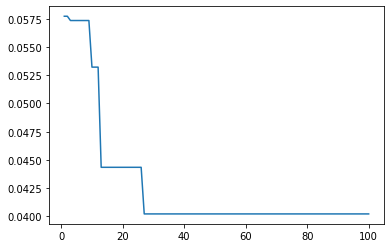

In [21]:
df_plot = df_training.query('bo_iteration>0')
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['bo_iteration']
y = df_plot['loss'].cummin()

plt.plot(x, y)
#plt.legend(title='Parameter where:')
plt.show()

number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196


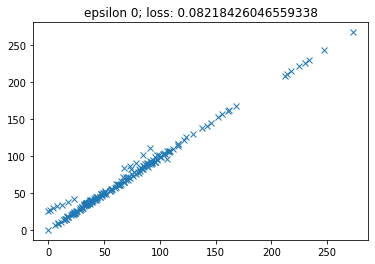

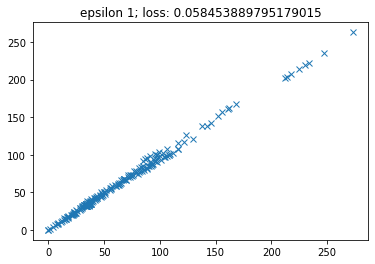

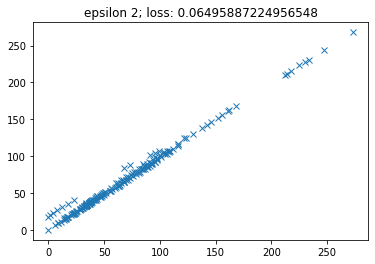

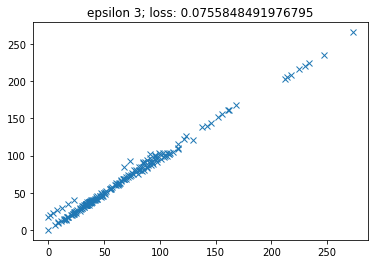

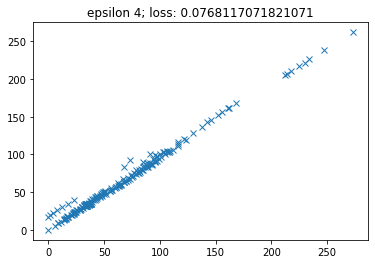

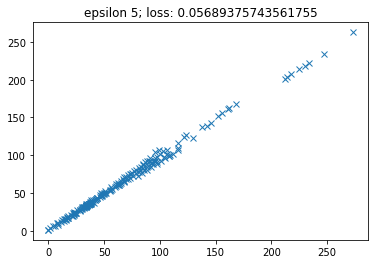

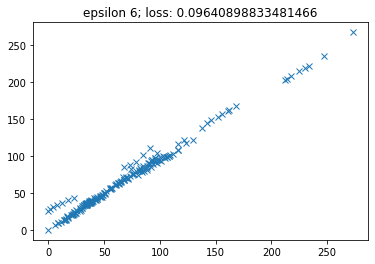

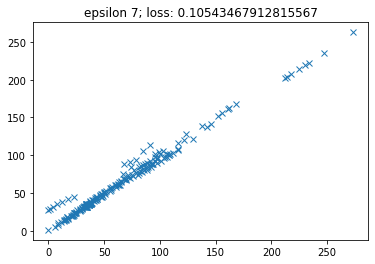

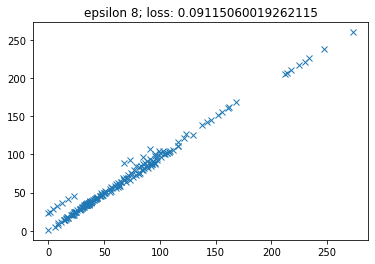

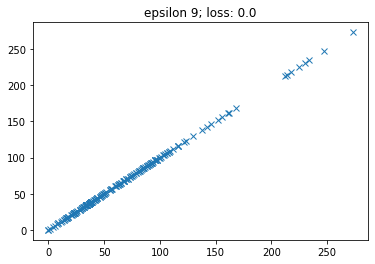

In [39]:
import matplotlib.pyplot as plt

for o1 in range(num_epsilon_iter):
    df1b = gt_edge_data.merge(edge_epsilon_all[o1], on=['edge_id'], how='left')
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, edge_epsilon_all[o1])

    plt.figure()
    plt.plot(df1b.interval_nVehContrib_x, df1b.interval_nVehContrib_y, 'x') 
    plt.title(f'epsilon {o1}; loss: {curr_loss}')
